In [1]:
import numpy as np
from scipy.stats import levy_stable
from scipy.special import erf, erfc
import matplotlib.pyplot as plt
import matplotlib

# Configure fonts for latex-like math rendering
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

#### **Tail-Aware Error Estimation**

The following function calculate the **rescaling factors** $ \xi_1 $ and $ \xi_2 $ for a desired confidence level $ 1-\epsilon $, given a bin size $ N_\text{bin} $.

It is designed for heavy-tailed distributions that fall in the domain of attraction of the **stable distribution**:
$$
\mathbf{S}(\alpha, \beta, \eta, \delta),
$$
with the characteristic exponent $ \alpha $ and skewness parameter $ \beta $ is known.

---

#### **Procedure for Constructing a Confidence Interval:**

Given parameters $ \alpha $ and $ \beta $, choose $ N_\text{bin} $ and calculate the corresponding $ \xi_1 $ and $ \xi_2 $ for the **$ (1 - \epsilon) $** confidence interval:

1. Bin the raw data into $ N_\text{bin} $ bins and compute the **bin-averaged values**.

2. Compute the **standard error of the mean** for the binned data:
   $$
   \mathrm{SE}_{N_{\text{bin}}} = \frac{s_{\text{bin}}}{\sqrt{N_{\text{bin}}}}
   $$

3. Construct the **$ (1 - \epsilon) $** confidence interval as:
   $$
   \left( \bar{X} - \xi_2 \cdot \mathrm{SE}_{N_{\text{bin}}},\ \bar{X} - \xi_1 \cdot \mathrm{SE}_{N_{\text{bin}}} \right)
   $$


In [2]:
def ci_estimation(
    alpha, beta, eps, bin_size=100, sample_size=10000, repeat=10, raw_output=False
):
    data = levy_stable.rvs(alpha, beta, size=[repeat, sample_size, bin_size])
    studentized_data = data.mean(-1) / data.std(-1) * np.sqrt(bin_size - 1)
    xi_1, xi_2 = np.percentile(
        studentized_data, [(eps / 2) * 100, (1 - eps / 2) * 100], axis=-1
    )
    return (xi_1, xi_2) if raw_output else (
            np.mean(xi_1),
            np.mean(xi_2),
            np.std(xi_1) / np.sqrt(repeat - 1),
            np.std(xi_2) / np.sqrt(repeat - 1),
        )

In [3]:
alpha_list = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
ci_res_list = [
    ci_estimation(alpha, beta=-1, eps=erfc(2 / 2**0.5), bin_size=100)
    for alpha in alpha_list
]
xi_1, xi_2, d_xi_1, d_xi_2 = zip(*ci_res_list)

Text(0, 0.5, '$\\xi$')

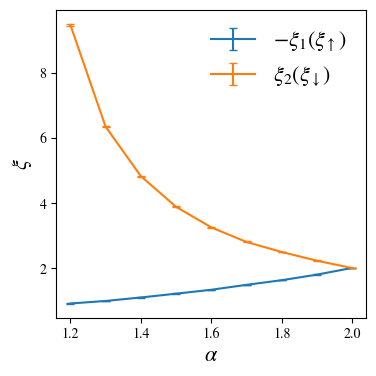

In [4]:
plt.figure(figsize=[4, 4])
plt.errorbar(alpha_list, -np.array(xi_1), d_xi_1, capsize=3, label=r"$-\xi_1 (\xi_{\uparrow})$")
plt.errorbar(alpha_list, xi_2, d_xi_2, capsize=3, label=r"$\xi_2 (\xi_{\downarrow})$")
plt.legend(fontsize=16, frameon=False)
plt.xlabel(r"$\alpha$", fontsize=16)
plt.ylabel(r"$\xi$", fontsize=16)

In [5]:
# Helper function for illustrating success & fail of errorbar
def errorbar_plot(ax, mean_list, err1_list, err2_list):
    fail_num = 0
    for i in range(len(mean_list)):
        mean_ = mean_list[i]
        err1_ = err1_list[i]
        err2_ = err2_list[i]
        if (exact_mean > mean_ + err2_) or (exact_mean < mean_ - err1_):
            fail_num += 1
            ax.errorbar([i],mean_,[[err1_], [err2_]],capsize=3,lw=1.0,fmt="s",ms=3,color="r")
        else:
            ax.errorbar([i], mean_,[[err1_], [err2_]],capsize=3,lw=1.0,fmt="s",ms=3,color="b")
    ax.hlines(exact_mean, 0, 50, color="k")
    return fail_num

Next we generate samples from 
$$
X = \frac{1}{Y^{1/\alpha}}
$$
with 
$$
Y \sim U(0,1)
$$
and 
$$
\mathbb{E}[X] = \frac{\alpha}{\alpha - 1}.
$$ 

This gives a heavy-tailed distribution with characteristic exponent $\alpha$ and skewness parameter $\beta = 1$.

We will check if the tail-aware error estimation method works.

In [6]:
alpha = 1.5
exact_mean = alpha / (alpha - 1)
bin_size = 100
xi_1, xi_2, _, _ = ci_estimation(alpha=alpha, beta=1, eps=erfc(2 / 2**0.5), bin_size=bin_size,sample_size=100000)

In [7]:
runs = 50
np.random.seed(42)
X_data = np.random.uniform(0, 1, [runs, 100000]) ** (-1 / alpha)  # generate X data

In [8]:
# sample mean & tail-aware error estimation for each run
def tail_aware_error_estimation(X_data, bin_size, xi_1, xi_2):
    mean_list = []
    err1_list = []
    err2_list = []
    for data in X_data:
        mean_list.append(np.mean(data))  # sample average
        binned_data = data.reshape([bin_size, -1]).mean(-1)  # bin average data
        sem = np.std(binned_data) / np.sqrt(bin_size - 1)  # sem of bin average data
        err1_list.append(np.abs(-xi_2 * sem))
        err2_list.append(-xi_1 * sem)
    return np.array(mean_list), np.array(err1_list), np.array(err2_list)

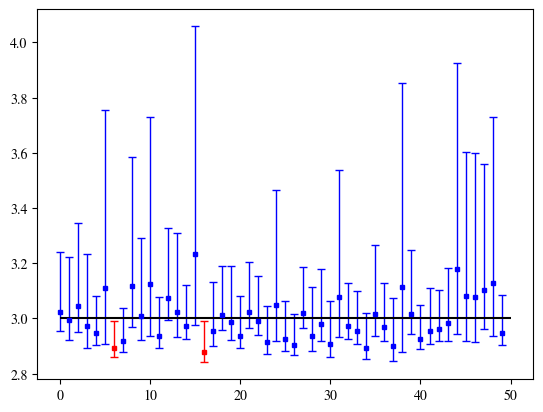

In [9]:
ax = plt.subplot(1, 1, 1)
fail_nums = errorbar_plot(ax, *tail_aware_error_estimation(X_data, bin_size, xi_1, xi_2))

This is a simple implementation of the **m-out-of-n bootstrap** method for estimating confidence intervals **without requiring prior knowledge of the tail behavior**.

For theoretical background, see:  
P. Hall and R. LePage, *On bootstrap estimation of the distribution of the studentized mean*,  
**Annals of the Institute of Statistical Mathematics**, **48**, 403–418 (1996).

In [10]:
def m_out_of_n_bootstrap(data, m, eps, n_bootstrap=1000):
    data = np.asarray(data)
    n = len(data)
    if m > n:
        raise ValueError("m must be less than or equal to the length of data")
    mean = np.mean(data)
    data_ = data - mean
    sample = np.random.choice(data_, size=[n_bootstrap, m], replace=True)
    bootstrap_stats = np.mean(sample, axis=-1) / np.std(sample, axis=-1) * np.sqrt(m)

    sem = np.std(data) / np.sqrt(len(data) - 1)
    err1 = np.percentile(bootstrap_stats, 100 * (1 - eps / 2)) * sem
    err2 = np.abs(np.percentile(bootstrap_stats, 100 * eps / 2)) * sem

    return mean, err1, err2

In [11]:
def bootstrap_error_estimation(
    X_data, m, bin_size=None, eps=erfc(2 / 2**0.5), n_bootstrap=10000
):
    mean_list = []
    err1_list = []
    err2_list = []
    for data in X_data:
        if bin_size is None:
            data_ = data
        else:
            data_ = (
                data[-bin_size * (len(data) // bin_size) :]
                .reshape([bin_size, -1])
                .mean(-1)
            )
        mean, err1, err2 = m_out_of_n_bootstrap(
            data_, m, eps=eps, n_bootstrap=n_bootstrap
        )
        mean_list.append(mean)
        err1_list.append(err1)
        err2_list.append(err2)
    return np.array(mean_list), np.array(err1_list), np.array(err2_list)

Comparison of Estimation Methods

We compare three error estimation methods on the same heavy-tailed dataset:

- **Tail-aware error estimation**
- **Bootstrap using raw data**
- **Bootstrap using bin-averaged data**

The **bootstrap on raw data** performs reasonably well and yields results similar to the tail-aware method, though it is **slightly less accurate**.

In contrast, the **bootstrap on bin-averaged data** performs much worse. This degradation is primarily due to the **loss of effective sample size** — averaging reduces the number of data points available for resampling, leading to poor estimation.

Text(0.1, 0.9, 'bootstrap using bin average data')

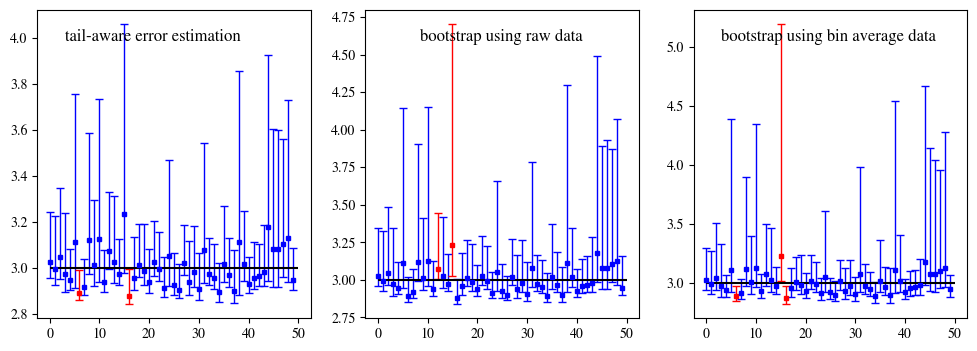

In [12]:
fig, axes = plt.subplots(1, 3, figsize=[12, 4])
ax1, ax2, ax3 = axes

fail_nums_1 = errorbar_plot(ax1, *tail_aware_error_estimation(X_data, bin_size, xi_1, xi_2))  # tail-aware error estimation
m = int(len(X_data[0]) ** 0.5)  # using m = sqrt(n)
fail_nums_2 = errorbar_plot(ax2, *bootstrap_error_estimation(X_data, m=m))  #  bootstrap using raw data without bin average
fail_nums_3 = errorbar_plot(ax3, *bootstrap_error_estimation(X_data, m=10, bin_size=100))  #  bootstrap using bin averaged data

ax1.text(0.1, 0.9, "tail-aware error estimation", transform=ax1.transAxes, fontsize=12)
ax2.text(0.2, 0.9, "bootstrap using raw data", transform=ax2.transAxes, fontsize=12)
ax3.text(0.1, 0.9, "bootstrap using bin average data", transform=ax3.transAxes, fontsize=12)


In [13]:
print(1-fail_nums_1/50, 1-fail_nums_2/50, 1-fail_nums_3/50)

0.96 0.96 0.94


**The discrepency is more evident for larger number of runs**

In [14]:
runs = 500
np.random.seed(42)
X_data = np.random.uniform(0, 1, [runs, 100000]) ** (-1 / alpha)  # generate X data

Text(0.1, 0.9, 'bootstrap using bin average data')

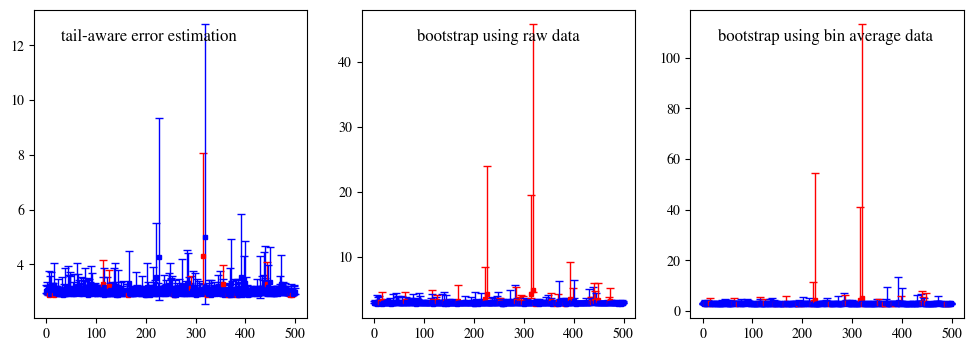

In [15]:
fig, axes = plt.subplots(1, 3, figsize=[12, 4])
ax1, ax2, ax3 = axes

fail_nums_1 = errorbar_plot(ax1, *tail_aware_error_estimation(X_data, bin_size, xi_1, xi_2))  # tail-aware error estimation
m = int(len(X_data[0]) ** 0.5)  # using m = sqrt(n)
fail_nums_2 = errorbar_plot(ax2, *bootstrap_error_estimation(X_data, m=m))  #  bootstrap using raw data without bin average
fail_nums_3 = errorbar_plot(ax3, *bootstrap_error_estimation(X_data, m=10, bin_size=100))  #  bootstrap using bin averaged data

ax1.text(0.1, 0.9, "tail-aware error estimation", transform=ax1.transAxes, fontsize=12)
ax2.text(0.2, 0.9, "bootstrap using raw data", transform=ax2.transAxes, fontsize=12)
ax3.text(0.1, 0.9, "bootstrap using bin average data", transform=ax3.transAxes, fontsize=12)

In [16]:
print(1-fail_nums_1/500, 1-fail_nums_2/500, 1-fail_nums_3/500)

0.97 0.94 0.9319999999999999
